---
# Objectives

1. Convert newick tree to PhyloXML format.
1. Fixes internal node names from an IQTREE tree. 
   - internal nodes by default get named the confidence (ex. "99/100")
   - this notebook instead gives them the name NODEi where i is an integer starting from 0.
   - NODE0 therefore becomes the root.
1. Convert tree to data frame.
1. Filter Outlier Tips
1. Combine metadata with tree data frame.

---
# Setup

## Module Imports

In [1]:
import pandas as pd
from Bio import Phylo
import os
import copy
from augur import utils, export_v2
import json
from matplotlib import colors, gridspec
import treetime # Clock filter tips
import time # Augur export

## Input File Paths

In [2]:
tree_path = "../../docs/results/latest/iqtree/iqtree-core_chromosome.filter5_post.cf.tree"
metadata_path = "../../docs/results/latest/metadata/metadata.tsv"
aln_path = "../../docs/results/latest/snippy_multi/snippy-core_chromosome.snps.filter5.aln"

outdir = "../../docs/results/latest/parse_tree"

# Create output directory if it doesn't exist
if not os.path.exists(outdir):
    os.mkdir(outdir)

## Variables

In [3]:
from config import *

# Custom script variables
SCRIPT_NAME = "parse_tree"
NAME_COL = "Sample"

## Import Metadata Dataframe

In [4]:
# Parse the metadata
metadata_df = pd.read_csv(metadata_path, sep='\t')

# Fix the problem with multiple forms of NA in the table
# Consolidate missing data to the NO_DATA_CHAR
metadata_df.fillna(NO_DATA_CHAR, inplace=True)

# set the metadata index
metadata_df.set_index(NAME_COL, inplace=True)

metadata_df

,Strain,Date,DateBP,Country,Province,CountryLat,CountryLon,ProvinceLat,ProvinceLon,Biovar,Branch_Major,Branch_Minor,BioSample,BioSampleComment,Branch_Number
Sample,,,,,,,,,,,,,,,
GCA_009909635.1_ASM990963v1_genomic,9_10,1923,-98,Russia,Rostov Oblast,64.6863,97.7453,47.6222,40.7958,Medievalis,2.MED,2.MED1,SAMN13632815,KEEP: Assembly Modern,2
GCA_009669545.1_ASM966954v1_genomic,42126,2006,-15,China,Xinjiang,35.0001,105,42.4805,85.4633,Antiqua,0.ANT,0.ANT1,SAMN07722925,KEEP: Assembly Modern,0
GCA_009669555.1_ASM966955v1_genomic,42123,2005,-16,China,Xinjiang,35.0001,105,42.4805,85.4633,Antiqua,0.ANT,0.ANT1,SAMN07722924,KEEP: Assembly Modern,0
GCA_009669565.1_ASM966956v1_genomic,42118,2005,-16,China,Xinjiang,35.0001,105,42.4805,85.4633,Antiqua,0.ANT,0.ANT1,SAMN07722923,KEEP: Assembly Modern,0
GCA_009669605.1_ASM966960v1_genomic,42117,2005,-16,China,Xinjiang,35.0001,105,42.4805,85.4633,Antiqua,0.ANT,0.ANT1,SAMN07722922,KEEP: Assembly Modern,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
IP283,IP283,1994,-27,India,Gujarat,22.3511,78.6677,22.385,71.7453,Orientalis,1.ORI,1.ORI3,IP283,KEEP: Local Modern,1
IP562,IP562,1947,-74,Iran,Kurdistan,32.6475,54.5644,35.6728,47.0124,Medievalis,2.MED,2.MED1,IP562,KEEP: Local Modern,2
IP542,IP542,1952,-69,Kenya,NA,1.44197,38.4314,NA,NA,Antiqua,1.ANT,1.ANT1,IP542,KEEP: Local Modern,1


---
# 1. Convert tree to PhyloXML format

In [5]:
tmp_xml = os.path.join(outdir, "temp.xml")
Phylo.convert(tree_path, "newick", tmp_xml, "phyloxml")

1

---
# 2. Fix internal node names

## Read in XML tree

In [6]:
# Read in the new tree
tree = Phylo.read(tmp_xml, "phyloxml")

# Deepest nodes first
tree.ladderize(reverse=False)

## Fix node names and confidences

In [7]:
# Counter for integer node names
node_i = 0

# Iterate through the nodes in the tree
for c in tree.find_clades():
    # Check if the name has 'accidentally' become the confidence vals
    ufboot_val = NO_DATA_CHAR    
    scf_val = NO_DATA_CHAR
    # If it's a named node, parse it
    if c.name:
        name_split = c.name.split("/")
        
        # Check if the name has 'accidentally' become the confidence vals
        if len(name_split) > 1:
            # Name the internal node
            c.name = "NODE" + str(node_i)    

            # Assign confidence values     
            ufboot_val = float(name_split[0])
            scf_val = float(name_split[1])
    # If it's not a named node, give it a name
    else:
        c.name = "NODE" + str(node_i) 
    
    ufboot_conf = Phylo.PhyloXML.Confidence(ufboot_val, type="ufboot")
    scf_conf = Phylo.PhyloXML.Confidence(scf_val, type="scf")
    
    c.confidences.append(ufboot_conf)
    c.confidences.append(scf_conf)
        
    # Increment node counter if not a terminal
    if not c.is_terminal():
        node_i += 1

---
# 3. Convert tree to dataframe

## Initialize the tree dataframe

In [8]:
# initialize empty dataframe
tree_df = pd.DataFrame(columns = [
    "Name",
    "UFboot", 
    "sCF", 
    "Branch_Length", 
    "Branch_Support_Color", 
    "coord_x", 
    "coord_y",]
)

for c in tree.find_clades():
    if not c.branch_length: c.branch_length = 0.0
    
    node_data = {
        "Name" : c.name,
        "UFboot" : [conf.value for conf in c.confidences if conf.type=="ufboot"][0],
        "sCF" :  [conf.value for conf in c.confidences if conf.type=="scf"][0],
        "Branch_Support_Color" :  NO_DATA_CHAR,
        "Branch_Length" :  c.branch_length,
        "coord_x" :  NO_DATA_CHAR,
        "coord_y" :  NO_DATA_CHAR,
    }
    
    tree_df = tree_df.append(node_data, ignore_index=True)

# Set the index to the node name
tree_df.set_index("Name", inplace=True)

# Visualize data frame
tree_df

,UFboot,sCF,Branch_Length,Branch_Support_Color,coord_x,coord_y
Name,,,,,,
NODE0,NA,NA,0.000000e+00,NA,NA,NA
SAMEA3541827,NA,NA,3.850400e-06,NA,NA,NA
NODE1,100,85,1.327080e-05,NA,NA,NA
SAMEA104233046,NA,NA,2.248400e-06,NA,NA,NA
NODE2,100,94.6,1.363640e-05,NA,NA,NA
...,...,...,...,...,...,...
NODE630,19,48.8,6.380000e-08,NA,NA,NA
GCA_000269245.1_ASM26924v1_genomic,NA,NA,2.230000e-07,NA,NA,NA
NODE631,37,49.6,2.936000e-07,NA,NA,NA


## Add plotting x and y coordinates of each node

In [9]:
x_posns = get_x_positions(tree)
y_posns = get_y_positions(tree)

# Add x and y coordinates as other attributes
for c in tree.find_clades():
    # x coordinates will be of branch length units
    coord_x = [value for key,value in x_posns.items() if key.name == c.name][0]
    # y coordinates will be arbitrary, based on number of tips
    coord_y = [value for key,value in y_posns.items() if key.name == c.name][0]
    # Add data to tree dataframe
    tree_df.at[c.name, 'coord_x'] = coord_x
    tree_df.at[c.name, 'coord_y'] = coord_y    

# Visualize dataframe
tree_df

,UFboot,sCF,Branch_Length,Branch_Support_Color,coord_x,coord_y
Name,,,,,,
NODE0,NA,NA,0.000000e+00,NA,0,17.8205
SAMEA3541827,NA,NA,3.850400e-06,NA,3.8504e-06,1
NODE1,100,85,1.327080e-05,NA,1.32708e-05,3.15625
SAMEA104233046,NA,NA,2.248400e-06,NA,1.55192e-05,2
NODE2,100,94.6,1.363640e-05,NA,2.69072e-05,4.3125
...,...,...,...,...,...,...
NODE630,19,48.8,6.380000e-08,NA,7.58989e-05,632.75
GCA_000269245.1_ASM26924v1_genomic,NA,NA,2.230000e-07,NA,7.61219e-05,632
NODE631,37,49.6,2.936000e-07,NA,7.61925e-05,633.5


## Add branch support color

In [10]:
for c in tree.find_clades():   
    # Default Color
    branch_color = LOW_COL
    # Terminal branches will be grey
    if c.is_terminal():
        branch_color = TERM_COL
    # High support branches
    ufboot_val = tree_df["UFboot"][c.name]
    scf_val = tree_df["sCF"][c.name]
    if scf_val != NO_DATA_CHAR and ufboot_val != NO_DATA_CHAR:
        if scf_val >= SCF_THRESH and ufboot_val >= UFBOOT_THRESH:
            branch_color = HIGH_COL
    tree_df.at[c.name, "Branch_Support_Color"] = branch_color            

tree_df

,UFboot,sCF,Branch_Length,Branch_Support_Color,coord_x,coord_y
Name,,,,,,
NODE0,NA,NA,0.000000e+00,black,0,17.8205
SAMEA3541827,NA,NA,3.850400e-06,grey,3.8504e-06,1
NODE1,100,85,1.327080e-05,black,1.32708e-05,3.15625
SAMEA104233046,NA,NA,2.248400e-06,grey,1.55192e-05,2
NODE2,100,94.6,1.363640e-05,black,2.69072e-05,4.3125
...,...,...,...,...,...,...
NODE630,19,48.8,6.380000e-08,black,7.58989e-05,632.75
GCA_000269245.1_ASM26924v1_genomic,NA,NA,2.230000e-07,grey,7.61219e-05,632
NODE631,37,49.6,2.936000e-07,black,7.61925e-05,633.5


---
# 4. Filter Outlier Tips

## Parse Tip Dates

In [11]:
# Use the utils function to parse the metadata dates
dates_raw = treetime.utils.parse_dates(metadata_path, 
                                   date_col=DATE_COL, 
                                   name_col = NAME_COL)

# Remove nan elements (internal nodes)
dates = {}
for k,v in dates_raw.items():
    if type(v) == list:
        dates[k] = v
    elif not pd.isnull(v):
        dates[k] = v
        
# Add Reference
dates["Reference"] = REF_DATE


Attempting to parse dates...
	Using column 'Sample' as name. This needs match the taxon names in the tree!!
	Using column 'Date' as date.


## Clock Filter


0.00	-TreeAnc: set-up

1.22	-SequenceData: loaded alignment.
1.22	--SequenceData.aln: specified sequence length doesn't match alignment
    	  length. Treating difference as constant sites.

1.22	-SeqData: making compressed alignment...

3.87	-SequenceData: constructed compressed alignment...
4.24	--ClockTree: Setting precision to level 2

4.34	-ClockTree._assign_dates: assigned date contraints to 634 out of 634 tips.
4.70	--ClockTree.date2dist: Setting new molecular clock. rate=9.508e-09,
    	  R^2=0.2300
4.72	---TreeTime.ClockFilter: marking GCA_000323485.1_ASM32348v1_genomic as
    	   outlier, residual -2.630435 interquartile distances
4.72	---TreeTime.ClockFilter: marking GCA_000323845.1_ASM32384v1_genomic as
    	   outlier, residual -2.648591 interquartile distances
4.72	---TreeTime.ClockFilter: marking GCA_001601675.1_ASM160167v1_genomic as
    	   outlier, residual 2.216493 interquartile distances
4.72	---TreeTime.ClockFilter: marking GCA_001972405.1_ASM197240v1_genomic as
 

/home/ktmeaton/miniconda3/envs/plague-phylogeography/lib/python3.7/site-packages/treetime/treeregression.py:561: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
No handles with labels found to put in legend.


Collapsed node NODE8 in the tree.
Collapsed node GCA_000323485.1_ASM32348v1_genomic in the tree.
Collapsed node GCA_000323845.1_ASM32384v1_genomic in the tree.
Collapsed node GCA_001601675.1_ASM160167v1_genomic in the tree.
Collapsed node GCA_001972405.1_ASM197240v1_genomic in the tree.
Collapsed node GCA_001972385.1_ASM197238v1_genomic in the tree.
Collapsed node GCA_001972415.1_ASM197241v1_genomic in the tree.
Collapsed node NODE263 in the tree.
Collapsed node GCA_000834275.1_ASM83427v1_genomic in the tree.
Collapsed node GCA_000834885.1_ASM83488v1_genomic in the tree.
Collapsed node NODE309 in the tree.
Collapsed node GCA_008630375.1_ASM863037v1_genomic in the tree.
Collapsed node GCA_008630375.2_ASM863037v2_genomic in the tree.
Collapsed node NODE352 in the tree.
Collapsed node GCA_003086075.1_ASM308607v1_genomic in the tree.
Collapsed node GCA_003086115.1_ASM308611v1_genomic in the tree.
Collapsed node GCA_001613865.1_ASM161386v1_genomic in the tree.
Dropped NODE8 from the datafra

/home/ktmeaton/miniconda3/envs/plague-phylogeography/lib/python3.7/site-packages/treetime/treeregression.py:561: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
No handles with labels found to put in legend.


Clock Model:  {'clock_rate': 9.327962569513804e-09, 'intercept': 5.2992847258503844e-05, 'chisq': 2.224434299608803e-08, 'r_val': 0.5228005426946797, 'cov': None, 'sigma': 0, 'valid_confidence': False}
Collapsed node NODE54 in the tree.
Collapsed node GCA_000382545.1_Yersinia_pestis_assem... in the tree.
Collapsed node GCA_001188335.1_DYA_1_genomic in the tree.
Dropped NODE54 from the dataframe.
Dropped GCA_000382545.1_Yersinia_pestis_assembly_genomic from the dataframe.
Dropped GCA_001188335.1_DYA_1_genomic from the dataframe.

0.00	-TreeAnc: set-up

1.13	-SequenceData: loaded alignment.
1.13	--SequenceData.aln: specified sequence length doesn't match alignment
    	  length. Treating difference as constant sites.

1.13	-SeqData: making compressed alignment...

3.54	-SequenceData: constructed compressed alignment...
3.61	---**WARNING: Number of tips in tree differs from number of sequences in
    	   alignment!**
3.82	--ClockTree: Setting precision to level 2

3.89	-ClockTree._assign_

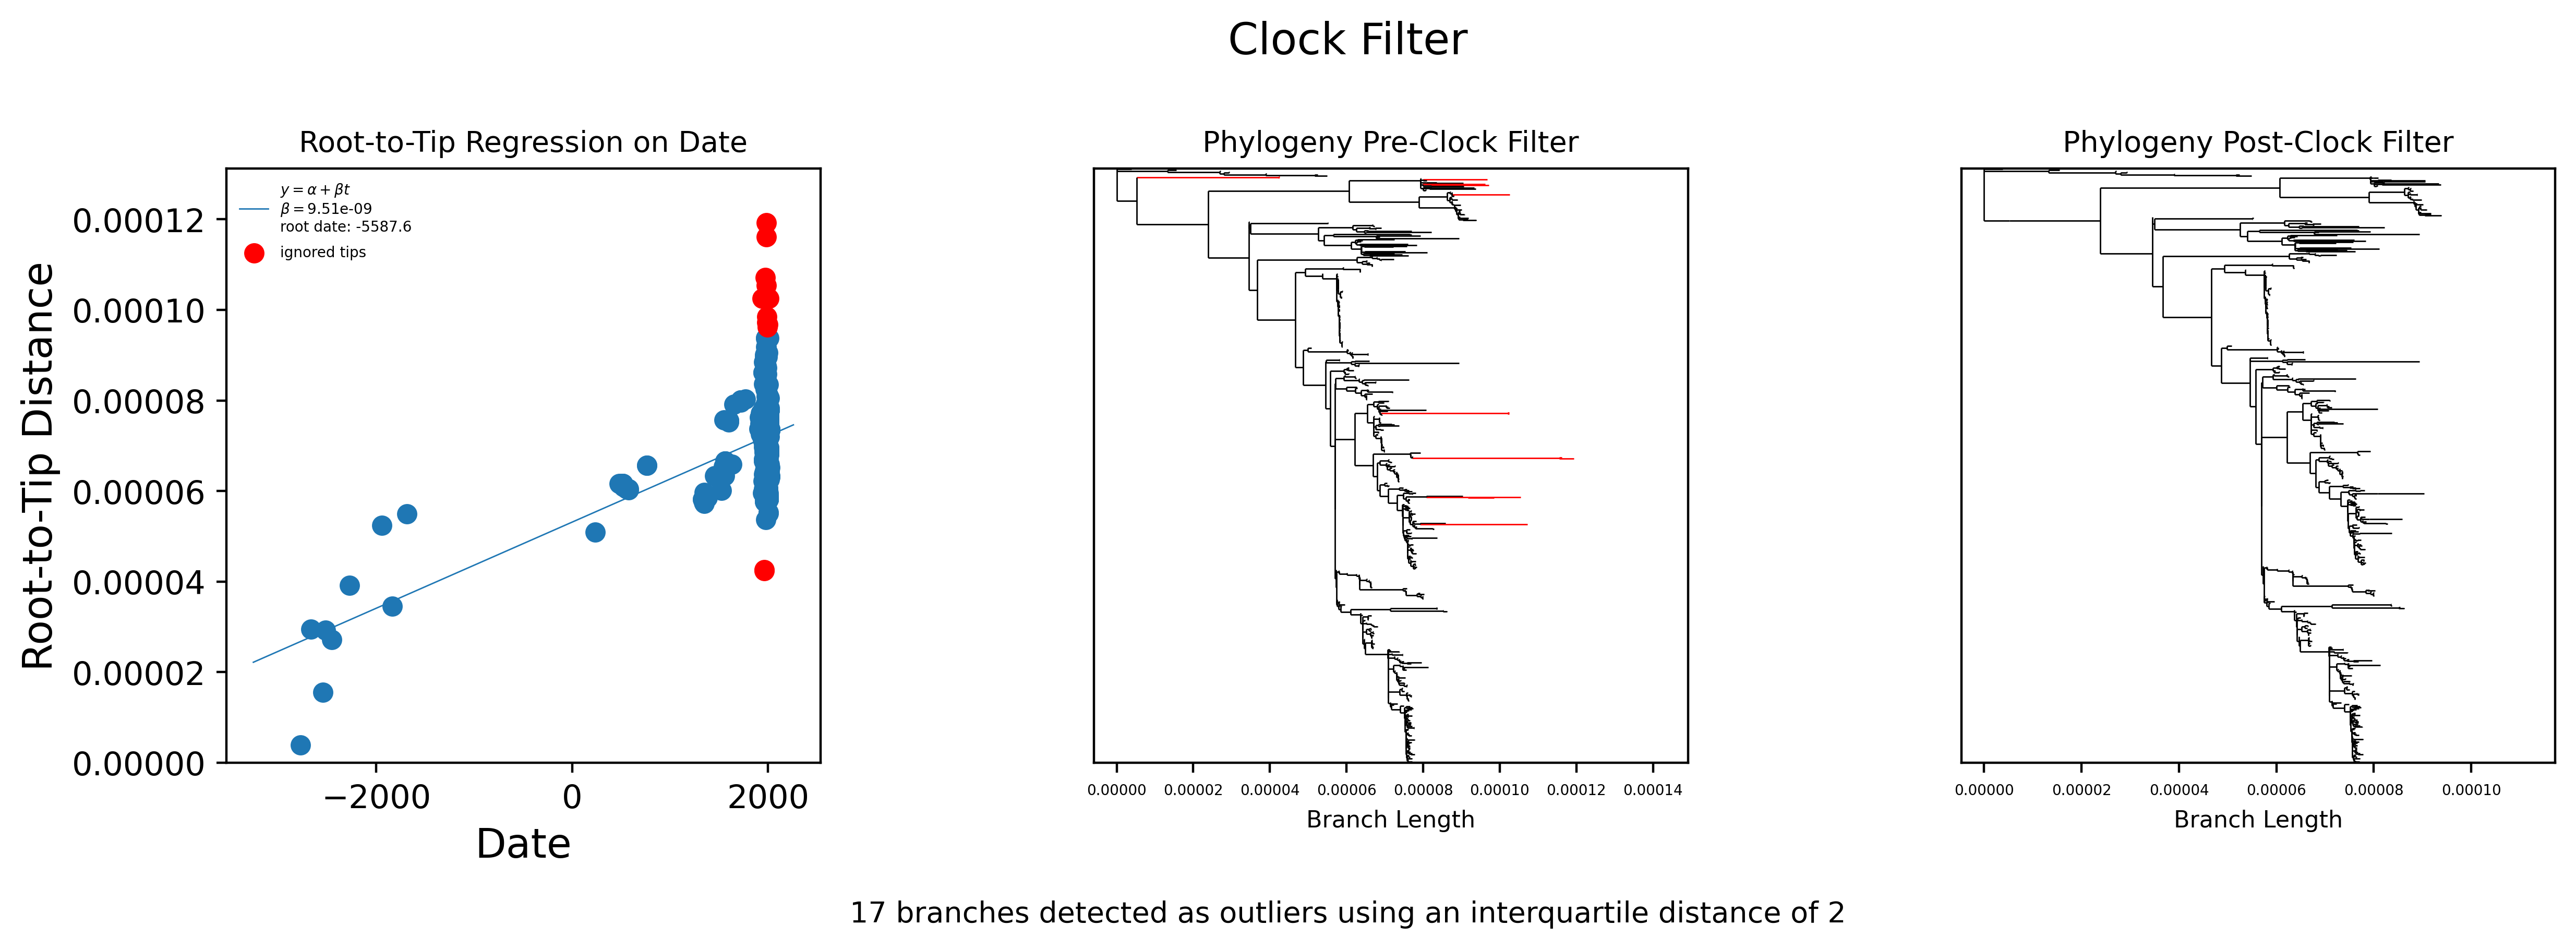

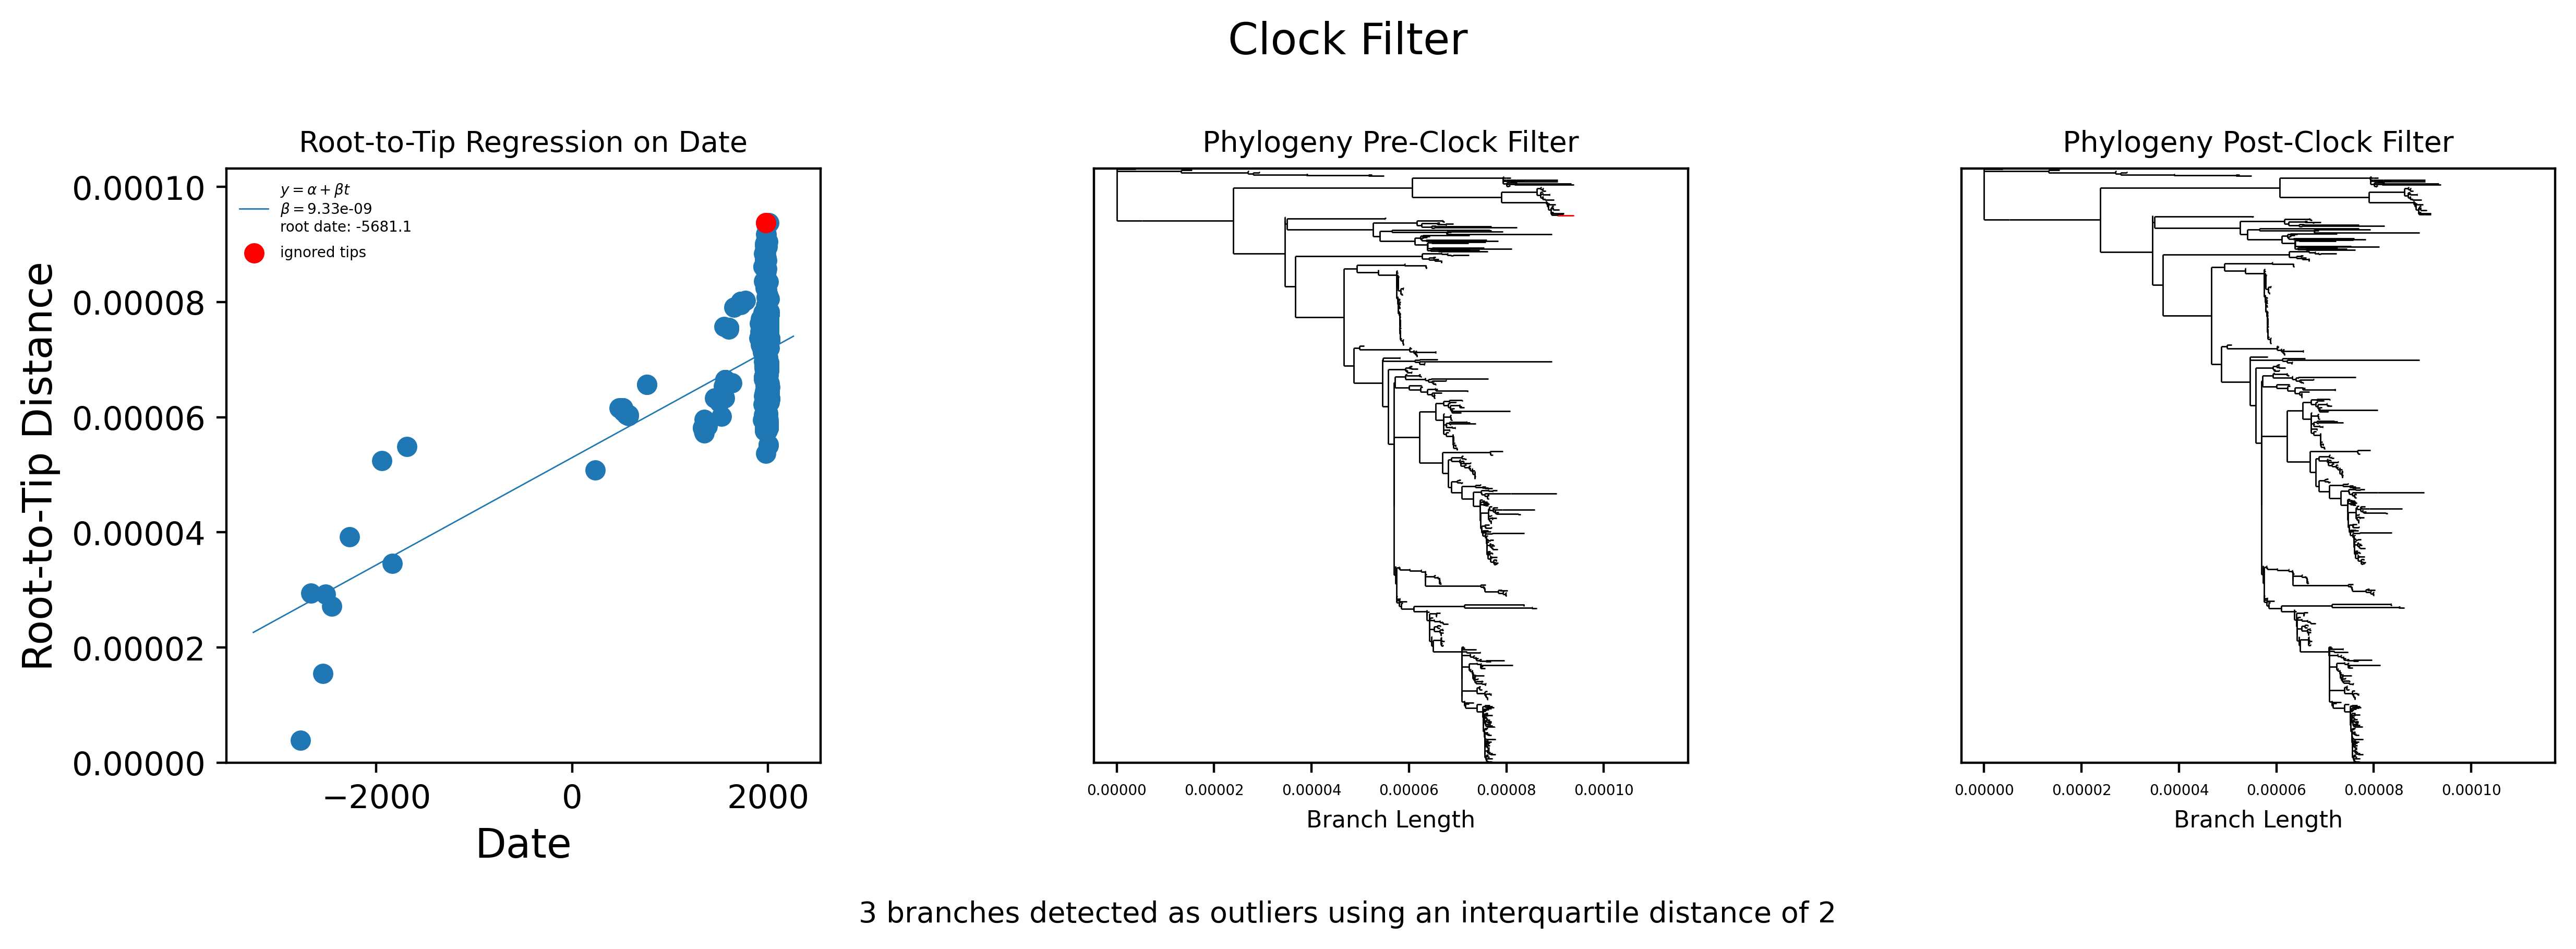

In [12]:
# Count the iterations needed
iter = 0
# A boolean to decide if we keep running the clock_filter
has_bad_branches = True

# Keep calculating and collapsing until no bad_branches
while has_bad_branches:
    
    iter += 1
    # Construct the treetime object
    # Remember, including the alignment is crucial!
    tt = treetime.TreeTime(dates=dates, 
                           aln=aln_path,                     
                           tree=tree, 
                           verbose=4, 
                           fill_overhangs=False,
                           seq_len=REF_LEN,                        
                          )

    # Remove outliers
    tt.clock_filter(reroot=None, 
                    n_iqd=N_IQD, 
                    plot=False,
                    )
        
    # Check rtt
    print("Clock Model: ", tt.date2dist.__dict__)
    has_bad_branches = True in [c.bad_branch for c in tt.tree.find_clades()]
    
    if has_bad_branches:
        # Setup the figure
        fig = plt.figure(constrained_layout=True, 
                         dpi=dpi,
                         figsize=(figsize[0] * 2, figsize[1] * 2),
                         )

        # Setup the grid
        gs = gridspec.GridSpec(3, 3, figure=fig, wspace=0.05)
        ax1 = fig.add_subplot(gs[0, 0])
        ax2 = fig.add_subplot(gs[0, 1])
        ax3 = fig.add_subplot(gs[0, 2])

        
        bad_clades = []
        bad_nodes = []

        for c in tt.tree.find_clades():
            if c.bad_branch:
                bad_clades.append(c.name)
                c.color = "red"
        
        # -----------------------------------------------------
        # Axis 1: Root To Tip Regression
        tt.plot_root_to_tip(add_internal=False, label=True, ax=ax1)
        # Labels
        ax1.set_xlabel("Date")
        ax1.set_ylabel("Root-to-Tip Distance")
        ax1.set_title("Root-to-Tip Regression on Date")
        
        # -----------------------------------------------------
        # Axis 2: Tree Pre-Clock Filter
        Phylo.draw(tt.tree, 
            show_confidence=False, 
            #label_func = lambda x: x.name if x.name in bad_clades else None,
            label_func = lambda x: '',
            do_show=False,
            axes=ax2)
        
        ax2.set_xlabel("Branch Length")
        ax2.set_yticks([])
        ax2.set_ylabel('')
        ax2.set_title("Phylogeny Pre-Clock Filter")
        
        # Collapse
        for b in bad_clades:
            # Possibly already collapsed if redundancy
            try:
                b_node = tt.tree.common_ancestor([b])
                for c in b_node.find_clades():
                    # Add to the list of bad nodes
                    bad_nodes.append(c)
                    tt.tree.collapse(target=c.name)
                    print("Collapsed node {} in the tree.".format(c))
            except ValueError:
                continue
        
        # Remove from dataframe
        for b in bad_clades:
            try:
                tree_df.drop(index=b, inplace=True)
                print("Dropped {} from the dataframe.".format(b))
            except KeyError:
                continue

        # -----------------------------------------------------
        # Axis 3: Tree Post-Clock Filter
        Phylo.draw(tt.tree, 
               show_confidence=False, 
               label_func = lambda x: x.name if x.name in bad_clades else None, 
               do_show=False,
               axes=ax3,
               )
        
        # Labels
        ax3.set_xlabel("Branch Length")
        ax3.set_yticks([])
        ax3.set_ylabel('')
        ax3.set_title("Phylogeny Post-Clock Filter")
        
        # Layout
        ratio = 1.0
        for ax in (ax1, ax2, ax3):
            x_left, x_right = ax.get_xlim()
            y_low, y_high = ax.get_ylim()
            ax.set_aspect(abs((x_right-x_left)/(y_low-y_high))*ratio)
        
        # Legend
        ax1.legend()
        
        # Figure Title
        plt.suptitle("Clock Filter", y=1.05, fontsize=15)

        caption_text = ("{} branches detected as outliers using an interquartile distance of {}".format(len(bad_nodes), N_IQD)                               )
        fig.text(0.5, 0.6, caption_text, ha='center', fontsize=10)

        # Save
        out_path = os.path.join(outdir, SCRIPT_NAME + "_clock_filter_{}.".format(iter) + FMT) 
        plt.savefig(out_path, dpi=dpi, bbox_inches = "tight")


---
# 5. Combine metadata into tree dataframe

## Parse metadata into df

In [13]:
# Parse the metadata
metadata_df = pd.read_csv(metadata_path, sep='\t')

# Fix the problem with multiple forms of NA in the table
# Consolidate missing data to the NO_DATA_CHAR
metadata_df.fillna(NO_DATA_CHAR, inplace=True)

# set the metadata index
metadata_df.set_index(NAME_COL, inplace=True)

metadata_df

,Strain,Date,DateBP,Country,Province,CountryLat,CountryLon,ProvinceLat,ProvinceLon,Biovar,Branch_Major,Branch_Minor,BioSample,BioSampleComment,Branch_Number
Sample,,,,,,,,,,,,,,,
GCA_009909635.1_ASM990963v1_genomic,9_10,1923,-98,Russia,Rostov Oblast,64.6863,97.7453,47.6222,40.7958,Medievalis,2.MED,2.MED1,SAMN13632815,KEEP: Assembly Modern,2
GCA_009669545.1_ASM966954v1_genomic,42126,2006,-15,China,Xinjiang,35.0001,105,42.4805,85.4633,Antiqua,0.ANT,0.ANT1,SAMN07722925,KEEP: Assembly Modern,0
GCA_009669555.1_ASM966955v1_genomic,42123,2005,-16,China,Xinjiang,35.0001,105,42.4805,85.4633,Antiqua,0.ANT,0.ANT1,SAMN07722924,KEEP: Assembly Modern,0
GCA_009669565.1_ASM966956v1_genomic,42118,2005,-16,China,Xinjiang,35.0001,105,42.4805,85.4633,Antiqua,0.ANT,0.ANT1,SAMN07722923,KEEP: Assembly Modern,0
GCA_009669605.1_ASM966960v1_genomic,42117,2005,-16,China,Xinjiang,35.0001,105,42.4805,85.4633,Antiqua,0.ANT,0.ANT1,SAMN07722922,KEEP: Assembly Modern,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
IP283,IP283,1994,-27,India,Gujarat,22.3511,78.6677,22.385,71.7453,Orientalis,1.ORI,1.ORI3,IP283,KEEP: Local Modern,1
IP562,IP562,1947,-74,Iran,Kurdistan,32.6475,54.5644,35.6728,47.0124,Medievalis,2.MED,2.MED1,IP562,KEEP: Local Modern,2
IP542,IP542,1952,-69,Kenya,NA,1.44197,38.4314,NA,NA,Antiqua,1.ANT,1.ANT1,IP542,KEEP: Local Modern,1


## Add metadata to tree and tree dataframe

In [14]:
# Iterate through the different metadata attributes
for attr in metadata_df.columns:
    # Initialize an empty column for the attribute
    tree_df[attr] = [NO_DATA_CHAR for row in range(0,len(tree_df))]
    # Iterate over the nodes in the tree
    for c in tree.find_clades():
        # Initialize to empty
        attr_val = NO_DATA_CHAR
        # If the node shows up in the metadata
        if c.name in metadata_df.index:
            tree_df.at[c.name, attr] = metadata_df[attr][c.name]
            attr_val = metadata_df[attr][c.name]         

tree_df

,UFboot,sCF,Branch_Length,Branch_Support_Color,coord_x,coord_y,Strain,Date,DateBP,Country,Province,CountryLat,CountryLon,ProvinceLat,ProvinceLon,Biovar,Branch_Major,Branch_Minor,BioSample,BioSampleComment,Branch_Number
Name,,,,,,,,,,,,,,,,,,,,,
NODE0,NA,NA,0.000000e+00,black,0,17.8205,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
SAMEA3541827,NA,NA,3.850400e-06,grey,3.8504e-06,1,RISE509,[-2876:-2677],[-4897:-4698],Russia,Krasnoyarsk Krai,64.6863,97.7453,63.3234,97.098,Bronze Age,0.PRE,0.PRE2,SAMEA3541827,KEEP: SRA Ancient,0
NODE1,100,85,1.327080e-05,black,1.32708e-05,3.15625,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
SAMEA104233046,NA,NA,2.248400e-06,grey,1.55192e-05,2,Gyvakarai1,[-2621:-2472],[-4642:-4493],Lithuania,Panevezys County,55.35,23.75,55.9156,25.0312,Bronze Age,0.PRE,0.PRE1,SAMEA104233046,KEEP: SRA Ancient,0
NODE2,100,94.6,1.363640e-05,black,2.69072e-05,4.3125,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
NODE630,19,48.8,6.380000e-08,black,7.58989e-05,632.75,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
GCA_000269245.1_ASM26924v1_genomic,NA,NA,2.230000e-07,grey,7.61219e-05,632,PY-113,2010,-11,Peru,La Libertad,-6.86997,-75.0459,-8,-78.5,Orientalis,1.ORI,1.ORI1,SAMN02141506,KEEP: Assembly Modern,1
NODE631,37,49.6,2.936000e-07,black,7.61925e-05,633.5,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA


## Add Reference Metadata

In [15]:
for col in tree_df.columns:
    if col in REF_META:
        tree_df.at["Reference", col] = REF_META[col]

---
# Export

## Save tree and tree dataframe

In [16]:
out_path_df = os.path.join(outdir, SCRIPT_NAME + ".tsv" )
tree_df.to_csv(out_path_df, sep="\t")

out_path_xml = os.path.join(outdir,  SCRIPT_NAME + ".xml" )
out_path_nwk = os.path.join(outdir, SCRIPT_NAME + ".nwk" )
out_path_nexus = os.path.join(outdir, SCRIPT_NAME + ".nexus" )
Phylo.write(tree, out_path_xml, 'phyloxml')
Phylo.write(tree, out_path_nwk, 'newick', format_branch_length='%1.{}f'.format(BRANCH_LEN_SIG_DIG))
Phylo.write(tree, out_path_nexus, 'nexus', format_branch_length='%1.{}f'.format(BRANCH_LEN_SIG_DIG))

1

## Save lat and lon

Write an output tsv that is:  
resolution   name   lat    lon

In [17]:
latlon_dict = {"Country": {}, "Province": {}}
out_path_lat_lon = os.path.join(outdir, SCRIPT_NAME + "_latlon.tsv")

# Columns in data frame will be ex: CountryLat, CountryLon
for c in tree.find_clades():
    # Iterate through each geographic level
    for level in latlon_dict:
        # Store the location name
        loc = tree_df[level][c.name]
        # If the node has location data and is new
        if loc != NO_DATA_CHAR and loc not in latlon_dict[level]:
            latlon_dict[level][loc] = {}
            latlon_dict[level][loc]["lat"] = tree_df[level + "Lat"][c.name]
            latlon_dict[level][loc]["lon"] = tree_df[level + "Lon"][c.name]

with open(out_path_lat_lon, "w") as outfile:
    for level in latlon_dict:
        for loc in latlon_dict[level]:
            outfile.write(level.lower() + "\t"
                         + loc + "\t"
                         + str(latlon_dict[level][loc]["lat"]) + "\t"
                         + str(latlon_dict[level][loc]["lon"]) + "\n"
                 )

## Save colors

Write an output tsv that is:
attribute   attribute_val   hex_color

In [18]:
out_path_colors = os.path.join(outdir, SCRIPT_NAME + "_colors.tsv")
file_colors = open(out_path_colors, "w")

tree_df["dummy_conf"] = [0 for row in range(0,len(tree_df))]

hex_dict = {}

for attr in ATTRIBUTE_LIST:
    # Create the color map
    attr_key = attr.lower()
    hex_dict[attr_key] = {}
    for t in tree.get_terminals():
        attr_val = tree_df[attr][t.name]
        if attr_val not in hex_dict[attr_key] and attr_val != NO_DATA_CHAR:
            hex_dict[attr_key][attr_val] = {}
            
    # Create the custom color map (pyplot)
    cmap = plt.get_cmap(CONT_COLOR_PAL, len(hex_dict[attr_key]))
    # Convert the color map to a list of RGB values
    cmaplist = [cmap(i) for i in range(cmap.N)]
    # Convert RGB values to hex colors
    attr_hex = [colors.to_hex(col) for col in cmaplist]
    
    # Assign colors to value
    for attr_val, attr_col in zip(hex_dict[attr_key], attr_hex):
        hex_dict[attr_key][attr_val] = attr_col   

for attr_key in hex_dict:
    for attr_val in hex_dict[attr_key]:
        file_colors.write(str(attr_key) + "\t" + str(attr_val) + "\t" + str(hex_dict[attr_key][attr_val]) + "\n")

file_colors.close()        

### JSON

This can then be used for auspice via:

```
augur export v2 \
  --auspice-config ../../../../config/auspice.config \
  --tree parse_tree.nwk \
  --node-data parse_tree.json \
  --output parse_tree_auspice.json \
  --lat-longs parse_tree_latlon.tsv \
  --colors parse_tree_colors.tsv
```

```
HOST="localhost" auspice view --datasetDir .
```


## Augur JSON

  - alignment (empty)
  - input_tree (tree_path)
  - nodes (node_dict)
  

In [19]:
# Exclude these internal variables for plotting
COLOR_KEYWORD_EXCLUDE = ["color", "coord", "branch_number"]

In [32]:
# There is no alignment used
node_data = {"alignment" : ""}
node_data["input_tree"] = tree_path
    
node_dict = {}

# Iterate through all nodes in the tree
for c in tree.find_clades():
    # Add the node to the dictionary
    node_dict[c.name] = {}
    # Iterate through all attributes in the dataframe
    for attr in tree_df.columns:
        attr_val = tree_df[attr][c.name]
        # Check if this attribute should be excluded
        exclude = False
        for keyword in COLOR_KEYWORD_EXCLUDE:
            if keyword in attr.lower():
                exclude = True    
        if not exclude:           
            # Fix numpy attr to float/int
            if type(attr_val) == np.float64:
                attr_val = float(attr_val)
            elif type(attr_val) == np.int64:               
                attr_val = int(attr_val)
            # Make attribute name in dict lowercase (ex. Branch_Length -> branch_length)
            node_dict[c.name][attr.lower()] = attr_val

        
# Add the dataframe information to the node dict for the json
node_data["nodes"] = node_dict

out_path_augur_json = os.path.join(outdir, SCRIPT_NAME + ".json" )
utils.write_json(data=node_data, file_name=out_path_augur_json, indent=2)

### Auspice

Manual edits of https://github.com/nextstrain/augur/blob/master/augur/export_v2.py

In [33]:
# Put in Config, Remove later
export_v2.configure_warnings()

# Initialize the auspice json
data_json = {"version": "v2", "meta": {"updated": time.strftime('%Y-%m-%d')}}

# parse input files
T = tree
node_data, node_attrs, node_data_names, metadata_names = export_v2.parse_node_data_and_metadata(tree, out_path_augur_json, None)

# Validate and load config file (could put this in try except)
export_v2.validate_auspice_config_v2("../../config/auspice.config")
print("Validation success.")
config = export_v2.read_config("../../config/auspice.config")

# set metadata structures
export_v2.set_title(data_json, config, config["title"])
export_v2.set_display_defaults(data_json, config)
export_v2.set_maintainers(data_json, config, config["maintainers"])
export_v2.set_build_url(data_json, config, config["build_url"])
export_v2.set_annotations(data_json, node_data)

# Set Colors
export_v2.set_colorings(
            data_json=data_json,
            config=export_v2.get_config_colorings_as_dict(config),
            node_data_colorings=node_data_names,
            provided_colors=utils.read_colors(out_path_colors),
            node_attrs=node_attrs,
            command_line_colorings=None,
            metadata_names=metadata_names,
        )

# Set Filters
export_v2.set_filters(data_json, config)

# Set Tree
data_json["tree"] = export_v2.convert_tree_to_json_structure(tree.root, node_attrs)
export_v2.set_node_attrs_on_tree(data_json, node_attrs)
export_v2.set_geo_resolutions(data_json, 
                    config, 
                    AUSPICE_GEO_RES, 
                    utils.read_lat_longs(out_path_lat_lon), 
                    node_attrs)

# Set panels
export_v2.set_panels(data_json, config, cmd_line_panels=None)

# Write outputs - For Local Rendering
out_path_auspice_local_json = os.path.join(outdir, SCRIPT_NAME + ".json" )
utils.write_json(data=data_json, file_name=out_path_auspice_local_json, indent=JSON_INDENT, include_version=False)
export_v2.validate_data_json(out_path_auspice_local_json)
print("Validation successful for local JSON.")

# Write outputs - For Remote Rendering
out_path_auspice_remote_json = os.path.join("../../auspice/", AUSPICE_PREFIX + SCRIPT_NAME.replace("_","-") + ".json" )
utils.write_json(data=data_json, file_name=out_path_auspice_remote_json, indent=JSON_INDENT, include_version=False)
export_v2.validate_data_json(out_path_auspice_remote_json)
print("Validation successful for remote JSON.")

Validating schema of '../../config/auspice.config'...
Validation success.


Validating produced JSON
Validating schema of '../../docs/results/latest/parse_tree/parse_tree.json'...
Validating that the JSON is internally consistent...
Validation of '../../docs/results/latest/parse_tree/parse_tree.json' succeeded.
Validation successful for local JSON.
Validating produced JSON
Validating schema of '../../auspice/plague-phylogeography_parse-tree.json'...
Validating that the JSON is internally consistent...
Validation of '../../auspice/plague-phylogeography_parse-tree.json' succeeded.
Validation successful for remote JSON.


---
## Cleanup

In [22]:
os.remove(tmp_xml)

DEPRECATED: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.

